#### DEM Differences and Volume Estimation ####

This notebook contains functions for comparing two raster surface files and estimating the volumes in the areas where they differ.  
The end result is two shapefiles, one containing areas of volumetric gain and one of volumetric loss.    
This is accomplished by subtracting the first surface heights from the second, then delineating areas where differences exceed a user-specified magnitude.  
The functions in this notebook depend on the open source libraries [GDAL](https://gdal.org/index.html), [Matplotlib](https://matplotlib.org/), [NumPy](https://numpy.org/), and [OpenCV](https://opencv.org/).  

In [2]:
from typing import Tuple
from pathlib import Path
import numpy as np
from osgeo import gdal, ogr, osr
import matplotlib.pyplot as plt
import cv2
import sys

##### User Inputs #####

Enter the path to each of the surface files to process, in chronological order. The directory of the first DEM file provided will be utilized for storage of temporary files as well as output of the final shapefiles.  

The other parameters are:

 - *minimum_vertical_difference* : the minimum amount of difference (in units of the surface files) to include in regions of change
 - *kernel_size_in_pixels* : the number of pixels to utilize in the morphological operations that clean up the regions of change (see details below)
 - *minimum_pixel_count_per_region* : the smallest number of connected pixels to consider a region of change

 
 **Note:** with minor modifications these parameters could be updated to be expressed in terms of area (in units of the surface files) and that may be more desirable for future applications.

In [3]:
first_surface_file = 'D:/Development/Code/Python/dem_differencing/2013.tif'
second_surface_file = 'D:/Development/Code/Python/dem_differencing/2023.tif'
working_dir = Path(first_surface_file).parent.absolute()

minimum_vertical_difference = 0.35
kernel_size_in_pixels = 2
minimum_pixel_count_per_region = 120

**Matching Spatial Details**

This function examines two raster files to confirm their spatial compatibility. It confirms that both raster files share:  
 - Spatial Reference (projection)
 - Pixel Dimensions
 - Pixel Layout

 If GDAL cannot determine that the two rasters represent the same region with the same pixels, an appropriate error message is output.

In [4]:
def matching_spatial_details(first_raster_file: str, second_raster_file: str) -> Tuple[bool, str]:  

    try:
        first_raster = gdal.Open(first_raster_file)
        second_raster = gdal.Open(second_raster_file)

        if first_raster.GetGeoTransform() != second_raster.GetGeoTransform():
            return (False, 'GeoTIFF pixel anchor position, size, or orientation are not equivalent.')

        if first_raster.GetProjection() != second_raster.GetProjection():
            return (False, 'GeoTIFF projections from header are not equivalent.')

        if first_raster.RasterXSize != second_raster.RasterXSize:
            return (False, 'GeoTIFF number of columns are not equivalent.')

        if first_raster.RasterYSize != second_raster.RasterYSize:
            return (False, 'GeoTIFF number of rows are not equivalent.')

        # close gdal datasets
        first_raster = None
        second_raster = None
    
    except:
        return (False, 'Raster IO Error in GDAL:\n' + str(sys.exc_info()[1]))

    return (True, 'GeoTIFF projections and pixel layouts match.')


**Compute Difference Array**

This function reads the pixel values from two raster files and returns a NumPy array containing the differences obtained by subtracting the *older* surface from the *newer* surface

In [5]:
def compute_difference_array(first_surface_file: str, second_surface_file: str) -> np.ndarray:

    first_surface = gdal.Open(first_surface_file)
    second_surface = gdal.Open(second_surface_file)

    first_surface_data = first_surface.ReadAsArray()
    second_surface_data = second_surface.ReadAsArray()

    first_surface = None
    second_surface = None

    return second_surface_data - first_surface_data

**Plotting Functions**

These helper functions encapsulate the Matplotlib visualization of raster data for comparative purposes and visual inspection.

In [6]:
def plot_array(data: np.ndarray, mask: np.ndarray = None, plot_size=(14,9)) -> None:

    # if no mask provided by user, create a blank mask (i.e. show all of 'data')
    if not isinstance(mask, np.ndarray):
        mask = np.zeros_like(data)
    
    plt.figure(figsize=plot_size)
    plt.imshow(np.ma.masked_array(data, mask))
    plt.colorbar()

def plot_arrays(data1: np.ndarray, data2: np.ndarray, mask1: np.ndarray = None, 
    mask2: np.ndarray = None, plot_size=(18, 6)) -> None:

    if not isinstance(mask1, np.ndarray):
        mask1 = np.zeros_like(data1)
    if not isinstance(mask2, np.ndarray):
        mask2 = np.zeros_like(data2)

    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_figwidth(plot_size[0])
    fig.set_figheight(plot_size[1])

    im = ax1.imshow(np.ma.masked_array(data1, mask1))
    fig.colorbar(im, ax=ax1, shrink=0.8)
    ax1.set_facecolor((0.4, 0.4, 0.4))

    im = ax2.imshow(np.ma.masked_array(data2, mask2))
    fig.colorbar(im, ax=ax2, shrink=0.8)
    ax2.set_facecolor((0.4, 0.4, 0.4))

**Step 01. Compute Differences**

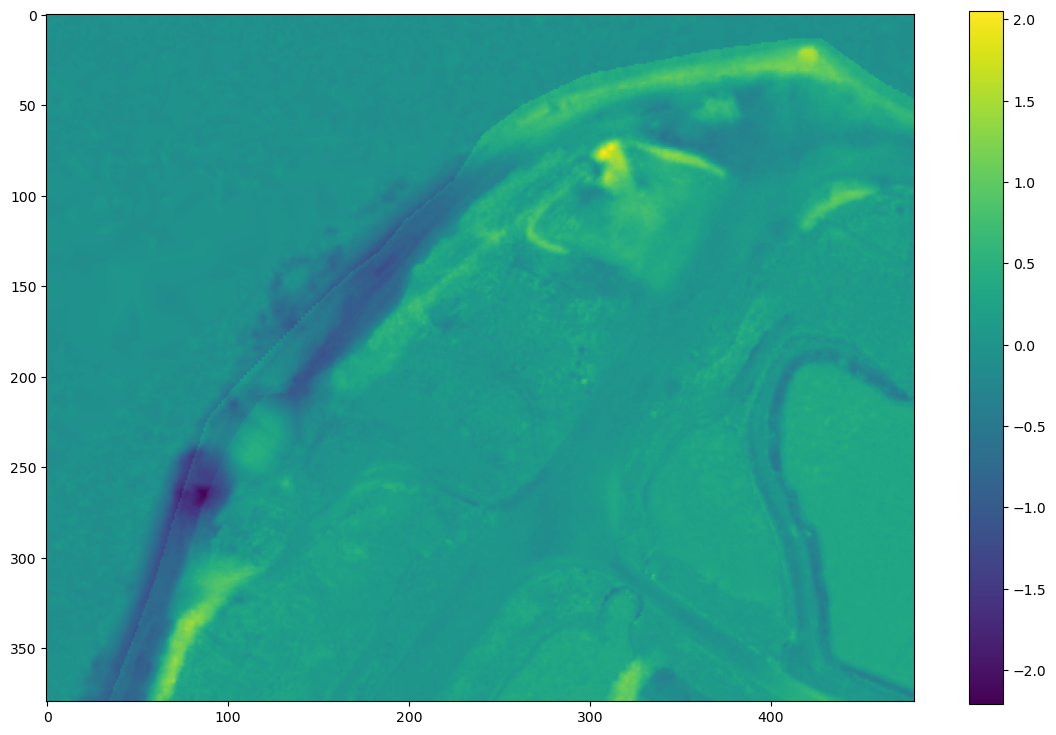

In [7]:
rasters_match, message = matching_spatial_details(first_surface_file, second_surface_file)

if rasters_match:
    differences = compute_difference_array(first_surface_file, second_surface_file)
    plot_array(differences)
else:
    raise ValueError('Inconsistent results encountered when attempting to process input rasters.\n' + message)

**Difference Masks**

These functions generate pixel-wise *masks* that will be utilized to isolate the areas of substantial change between the two rasters.

In [8]:
def positive_change_mask(difference_array: np.ndarray, minimum_difference: float) -> np.ndarray:
    return difference_array < minimum_difference

def negative_change_mask(difference_array: np.ndarray, minimum_difference: float) -> np.ndarray:
    return difference_array > -minimum_difference

**Step 02. Identify Preliminary Areas of Change**

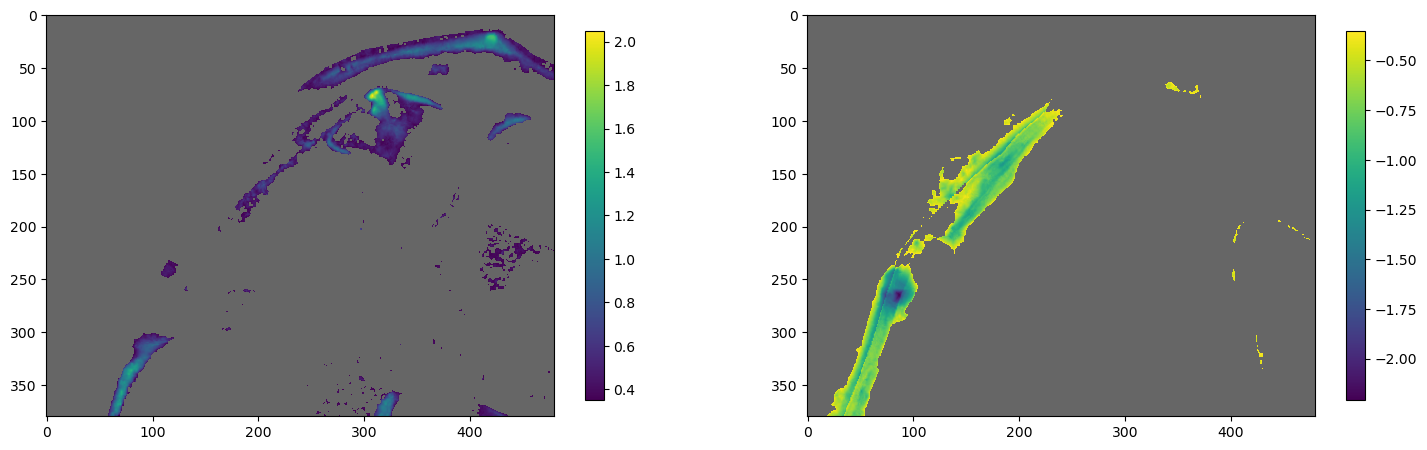

In [9]:
positive_mask = positive_change_mask(differences, minimum_vertical_difference)
negative_mask = negative_change_mask(differences, minimum_vertical_difference)
plot_arrays(differences, differences, positive_mask, negative_mask)

**Clean Mask**

This function takes previously generated rough areas of change and cleans them using image processing techniques.  
A kernel of user-specified size is utilized to perform *opening* and *closing* morphological operations, in an attempt to denoise the preliminary delineations found above.

In [10]:
def clean_mask(mask: np.ndarray, kernel_size: int) -> np.ndarray:
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size, kernel_size))

    # 'open' image to remove small, isolated noise
    updated_mask = cv2.morphologyEx(np.uint8(mask), cv2.MORPH_OPEN, kernel)

    # 'close' image to fill in small gaps
    return cv2.morphologyEx(updated_mask, cv2.MORPH_CLOSE, kernel)

**Step 03. Clean Initial Regions**

The cleaning function defined above smooths out the edges of the preliminary regions. Note this will change the extent of vertical differences seen in each region as the boundary will change slightly.

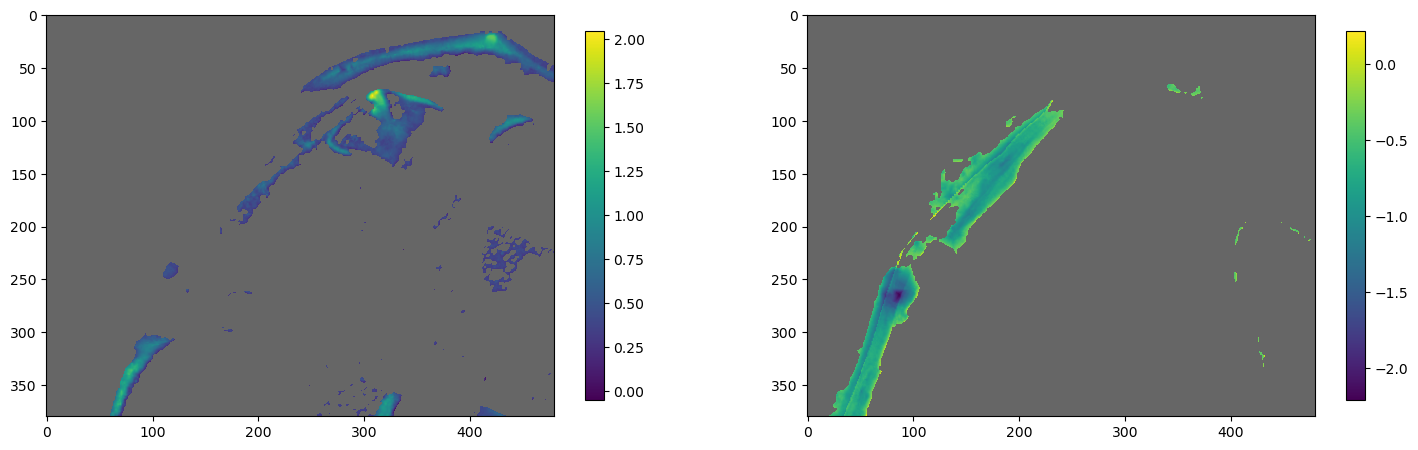

In [11]:
positive_mask = clean_mask(positive_mask, kernel_size_in_pixels)
negative_mask = clean_mask(negative_mask, kernel_size_in_pixels)
plot_arrays(differences, differences, positive_mask, negative_mask)

**Identify Regions**

Prior to this stage our region *masks* are binary arrays, either a pixel is included or not. We would like to treat each region as a distinct batch of pixels in order to perform further computations.  

This is accomplished using *connected components*, an image processing technique that identifies grouped regions of pixels of the same value.  

A user-specified minimum pixel count determines how small of a batch of pixels will be considered a region for further processing.

In [12]:
def identify_regions(mask: np.ndarray, minimum_pixel_count: int) -> np.ndarray:

    # numpy masked arrays use 1 to indicate masked pixels, so invert for OpenCV to only
    # evaluate regions that are not masked
    opencv_mask = 1 - np.uint8(mask)

    # using connectivity=8 includes pixels connected diagonally as well (alternatively connectivity=4 does not)
    _, region_map, stats, _ = cv2.connectedComponentsWithStats(opencv_mask, connectivity=8)
    pixels_per_region = stats[0:,4]

    # opencv structures the stats as a 2D array where the first row is for region 0 which in our case
    # winds up being all of the pixels that aren't masked, so we can skip over it

    for i in range(1, len(pixels_per_region)):
        if pixels_per_region[i] < minimum_pixel_count:
            region_map[region_map == i] = 0

    return region_map

**Step 04. Identify Distinct Regions**

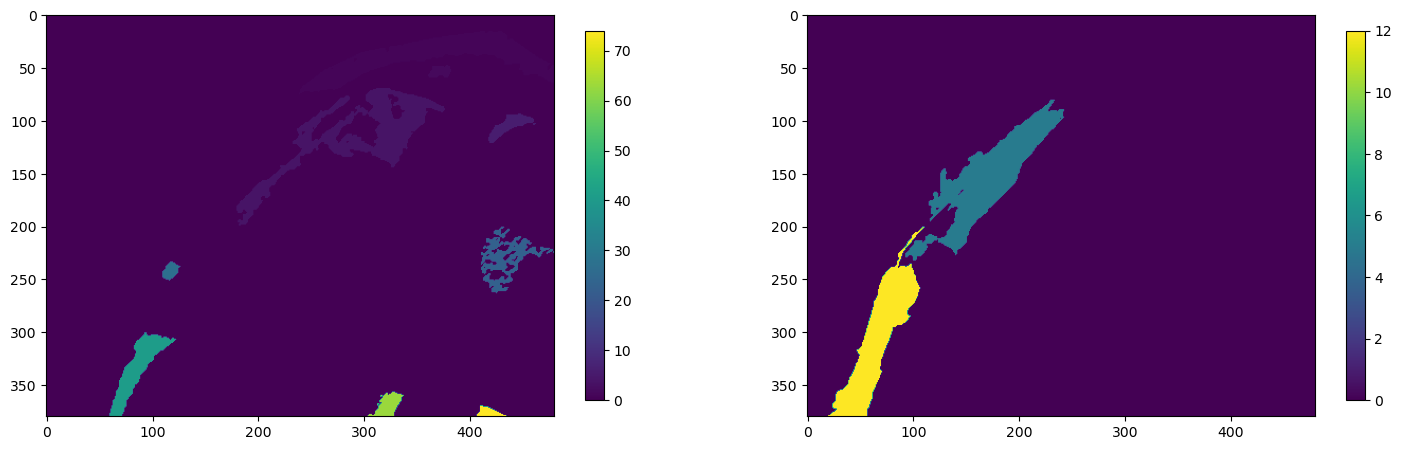

In [13]:
positive_change_regions = identify_regions(positive_mask, minimum_pixel_count_per_region)
negative_change_regions = identify_regions(negative_mask, minimum_pixel_count_per_region)
plot_arrays(positive_change_regions, negative_change_regions)

**Generate Region Raster**

This function takes the output from the *connected components* processing above and stores the distinctly identified regions to a raster for use in subsequent processing.

In [14]:
def generate_region_raster(template_raster_file: str, output_file: str, region_map: np.ndarray) -> None:

    try:        

        # retrieve layout info from template raster dataset
        template_dataset = gdal.Open(template_raster_file)
        geotransform = template_dataset.GetGeoTransform()
        spatialreference = template_dataset.GetProjection()
        ncol = template_dataset.RasterXSize
        nrow = template_dataset.RasterYSize
        nband = 1
        template_dataset = None
        
        # create output mask file as GeoTIFF
        driver = gdal.GetDriverByName("GTiff")
        region_dataset = driver.Create(output_file, ncol, nrow, nband, gdal.GDT_Byte)
        region_dataset.SetGeoTransform(geotransform)
        region_dataset.SetProjection(spatialreference)
        region_dataset.GetRasterBand(1).WriteArray(region_map)
        region_dataset = None

    except:
        print('Raster IO Error in GDAL:\n' + str(sys.exc_info()[1]))   

**Polygonize Region Raster**

This function utilizes a GDAL routine to convert rasters into polygons. It takes as input a saved region raster and generates an ESRI Shapefile containing the boundaries of each region.

In [15]:
def polygonize_region_raster(region_raster_file: str, output_vector_file: str) -> None:

    try:
        
        # open region map and extract projection info
        region_map_raster = gdal.Open(region_raster_file)
        input_prj = region_map_raster.GetProjection()

        # create new shapefile using region map projection
        driver = ogr.GetDriverByName('ESRI Shapefile')
        polygon_dataset = driver.CreateDataSource(output_vector_file)
        output_prj = osr.SpatialReference(wkt=input_prj)

        # specify field for attribute table in shapefile        
        output_layer = polygon_dataset.CreateLayer('Regions', srs = output_prj)
        field = ogr.FieldDefn('RegionID', ogr.OFTInteger)
        output_layer.CreateField(field)

        # polygonize regions from raster using GDAL, then remove feature for RegionID 0 (whole image)
        gdal.Polygonize(region_map_raster.GetRasterBand(1), None, output_layer, 0, [], callback=None)        
        for feature in output_layer:
            if feature.GetField('RegionID') == 0:
                output_layer.DeleteFeature(feature.GetFID())
        polygon_dataset.ExecuteSQL('repack Regions')

        # close both raster and vector files
        polygon_dataset.Destroy()
        region_map_raster = None

    except:
        print('IO or Operation error GDAL:\n' + str(sys.exc_info()[1]))   

**Step 05. Vectorize Distinct Regions**

In [16]:
positive_change_raster = str(working_dir.joinpath('positive_region_map.tif'))
generate_region_raster(first_surface_file, positive_change_raster, positive_change_regions)

gain_shapefile = str(working_dir.joinpath('Volumetric_Gain_Areas.shp'))
polygonize_region_raster(positive_change_raster, gain_shapefile)

negative_change_raster = str(working_dir.joinpath('negative_region_map.tif'))
generate_region_raster(first_surface_file, negative_change_raster, negative_change_regions)

loss_shapefile = str(working_dir.joinpath('Volumetric_Loss_Areas.shp'))
polygonize_region_raster(negative_change_raster, loss_shapefile)

**Compute Volumes**

This function utilizes the initial differences between the two rasters, and a region raster, to compute an estimate of the volumetric change per region.  

Postive values indicate increase in surface material; negative values indicate loss.  

At present this function assumes North-up rasters.  

The previously created ESRI Shapefiles are re-opened and a *Volume* field as added to their attribute table, and subsequently populated.

In [17]:
def compute_volumes(difference_data: np.ndarray, region_raster_file: str, region_shapefile: str) -> None:

    try:

        # open region raster and extract pixel dimensions and region map
        # definition of contents of GeoTransform taken from 
        # https://gdal.org/tutorials/geotransforms_tut.html
        # for North = Up images pixel height is negative in transform
        region_raster = gdal.Open(region_raster_file)
        transform = region_raster.GetGeoTransform()
        pixel_width = transform[1]
        pixel_height = abs(transform[5])
        region_map = region_raster.ReadAsArray()

        # as we presently have per-pixel differences, we need each difference pixel
        # multiplied by its width x its height to obtain per-pixel volumes
        volume_multiplier = pixel_width * pixel_height

        # open region shapefile for modification and add field for volume
        region_vectors = ogr.Open(region_shapefile, 1)
        region_layer = region_vectors.GetLayer()
        field = ogr.FieldDefn('Volume', ogr.OFTReal)
        region_layer.CreateField(field)

        # for each region in the shapefile / map, compute the sum of all per-pixel volumes
        for feature in region_layer:
            region_id = feature.GetField('RegionID')
            pixels = difference_data[region_map == region_id]
            total = sum(volume_multiplier * pixels)
            feature.SetField('Volume', total)
            region_layer.SetFeature(feature)

        # close raster and vector datasets
        region_raster = None
        region_vectors.Destroy()

    except:
        print('Processing Error Encountered:\n' + str(sys.exc_info()[1]))   


**Step 06. Compute Volumes**

In [18]:
compute_volumes(differences, positive_change_raster, gain_shapefile)
Path(positive_change_raster).unlink()

compute_volumes(differences, negative_change_raster, loss_shapefile)
Path(negative_change_raster).unlink()